In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('../../store.csv',index_col=0)

data

,Date,Open,High,Low,Close,Volume
0,2014-04-10,12937.40,13055.60,12881.20,12949.40,0
1,2014-04-11,12822.20,12934.90,12778.00,12840.20,0
2,2014-04-15,12830.50,12831.60,12537.70,12579.90,0
3,2014-04-16,12557.40,12727.00,12514.80,12563.20,0
4,2014-04-17,12564.50,12819.10,12514.80,12787.20,0
...,...,...,...,...,...,...
2465,2024-04-03,47350.25,47676.95,47279.80,47624.25,0
2466,2024-04-04,48086.20,48254.65,47712.70,48060.80,0
2467,2024-04-05,48104.65,48557.40,47894.50,48493.05,0
2468,2024-04-08,48586.75,48716.95,48424.65,48581.70,0


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2014-04-10,12949.40
1,2014-04-11,12840.20
2,2014-04-15,12579.90
3,2014-04-16,12563.20
4,2014-04-17,12787.20
...,...,...
2465,2024-04-03,47624.25
2466,2024-04-04,48060.80
2467,2024-04-05,48493.05
2468,2024-04-08,48581.70


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\91952\AppData\Local\Temp\ipykernel_2304\1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


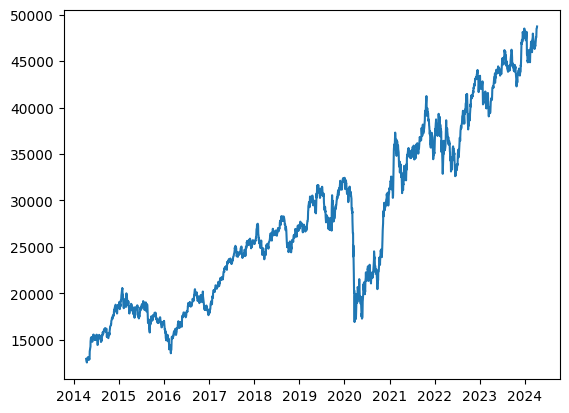

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-04-23,13122.10,12987.10,12958.50,12787.20,12563.20,12579.90,12840.20,12949.40
2014-04-25,13034.50,13122.10,12987.10,12958.50,12787.20,12563.20,12579.90,12840.20
2014-04-28,13081.50,13034.50,13122.10,12987.10,12958.50,12787.20,12563.20,12579.90
2014-04-29,12910.50,13081.50,13034.50,13122.10,12987.10,12958.50,12787.20,12563.20
2014-04-30,12855.80,12910.50,13081.50,13034.50,13122.10,12987.10,12958.50,12787.20
...,...,...,...,...,...,...,...,...
2024-04-03,47624.25,47545.45,47578.25,47124.60,46785.95,46600.20,46863.75,46684.90
2024-04-04,48060.80,47624.25,47545.45,47578.25,47124.60,46785.95,46600.20,46863.75
2024-04-05,48493.05,48060.80,47624.25,47545.45,47578.25,47124.60,46785.95,46600.20


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[13122.1 , 12987.1 , 12958.5 , ..., 12579.9 , 12840.2 , 12949.4 ],
       [13034.5 , 13122.1 , 12987.1 , ..., 12563.2 , 12579.9 , 12840.2 ],
       [13081.5 , 13034.5 , 13122.1 , ..., 12787.2 , 12563.2 , 12579.9 ],
       ...,
       [48493.05, 48060.8 , 47624.25, ..., 47124.6 , 46785.95, 46600.2 ],
       [48581.7 , 48493.05, 48060.8 , ..., 47578.25, 47124.6 , 46785.95],
       [48730.55, 48581.7 , 48493.05, ..., 47545.45, 47578.25, 47124.6 ]])

In [7]:
shifted_df_as_np.shape

(2463, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98439056, -0.99188018, -0.99346728, ..., -0.99907081,
        -0.98458774, -0.97851185],
       [-0.98927234, -0.98432555, -0.99186354, ..., -1.        ,
        -0.99907081, -0.98458774],
       [-0.98665312, -0.98922767, -0.98429343, ..., -0.98753665,
        -1.        , -0.99907081],
       ...,
       [ 0.98676458,  0.97085034,  0.95041019, ...,  0.92299432,
         0.90415185,  0.89381673],
       [ 0.99170488,  0.99503913,  0.97488967, ...,  0.94823538,
         0.92299432,  0.90415185],
       [ 1.        ,  1.        ,  0.99912804, ...,  0.94641039,
         0.94823538,  0.92299432]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2463, 7), (2463,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.97851185, -0.98458774, -0.99907081, ..., -1.        ,
        -0.99346728, -0.99188018],
       [-0.98458774, -0.99907081, -1.        , ..., -0.99040911,
        -0.99186354, -0.98432555],
       [-0.99907081, -1.        , -0.98753665, ..., -0.98880783,
        -0.98429343, -0.98922767],
       ...,
       [ 0.89381673,  0.90415185,  0.92299432, ...,  0.94607434,
         0.95041019,  0.97085034],
       [ 0.90415185,  0.92299432,  0.94823538, ...,  0.95048626,
         0.97488967,  0.99503913],
       [ 0.92299432,  0.94823538,  0.94641039, ...,  0.97492819,
         0.99912804,  1.        ]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

2339

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2339, 7), (124, 7), (2339,), (124,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2339, 7, 1), (124, 7, 1), (2339, 1), (124, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2339, 7, 1]),
 torch.Size([124, 7, 1]),
 torch.Size([2339, 1]),
 torch.Size([124, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.365

Val Loss: 0.900
***************************************************

Epoch: 2
Batch 100, Loss: 0.200

Val Loss: 0.610
***************************************************

Epoch: 3
Batch 100, Loss: 0.066

Val Loss: 0.153
***************************************************

Epoch: 4
Batch 100, Loss: 0.015

Val Loss: 0.098
***************************************************

Epoch: 5
Batch 100, Loss: 0.009

Val Loss: 0.068
***************************************************

Epoch: 6
Batch 100, Loss: 0.006

Val Loss: 0.043
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.030
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.027
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.021
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.017
********************************

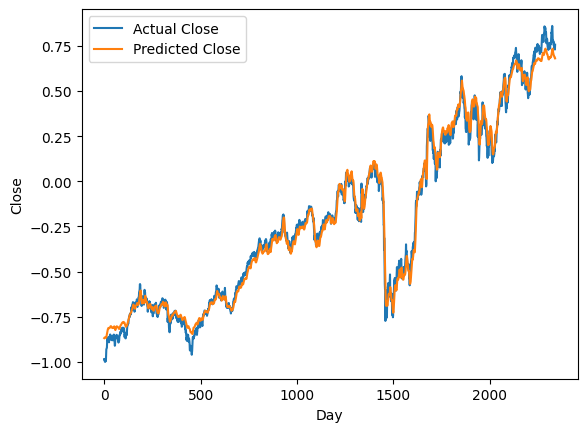

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([15207.05537141, 15235.0019605 , 15259.54520286, ...,
       43073.8486996 , 43079.9644559 , 43007.42247351])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([13122.10014116, 13034.49979344, 13081.49956243, ...,
       44360.60040254, 43886.49987227, 44360.09984746])

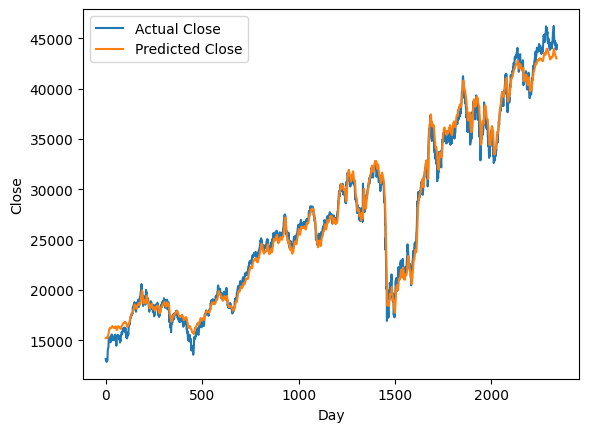

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([43036.7220587 , 43085.66308297, 43140.7915242 , 43134.47469022,
       43112.66631824, 43122.82822811, 43046.96097704, 42958.25256294,
       42883.79499477, 42728.35873807, 42555.71322658, 42324.15730214,
       42238.42440991, 42239.75922346, 42220.3006795 , 42184.89496407,
       42223.37460108, 42313.15043819, 42443.14608989, 42556.6362587 ,
       42622.93199821, 42673.89556448, 42731.9396321 , 42799.01294328,
       42826.2493431 , 42894.98582341, 42938.27207266, 42869.76768734,
       42811.33109042, 42781.33201159, 42716.39247688, 42692.62787575,
       42709.07881098, 42746.23967787, 42902.06525519, 43006.82779696,
       43137.28977776, 43498.15469502, 43848.14109578, 44065.82800799,
       44213.89070332, 44364.79950349, 44474.84675178, 44515.13929661,
       44523.20379512, 44612.90369332, 44736.6627282 , 44787.03054837,
       44818.27245839, 44778.33821688, 44804.11359482, 44773.55406544,
       44778.24088672, 44855.70285494, 44945.42842263, 44979.87474081,
      

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([44516.89979589, 44599.20046322, 44287.90012496, 44225.89974699,
       44409.49971389, 43888.69996158, 43754.49986111, 43723.09965589,
       43151.20050292, 42832.00037872, 42280.09989859, 42782.00048793,
       43039.09969533, 42845.90040825, 42700.89986932, 43017.20041057,
       43318.19979589, 43619.40025889, 43737.90025674, 43658.59971121,
       43683.5996566 , 43820.10038523, 43996.5995291 , 43891.1995283 ,
       44201.69983408, 44161.59981043, 43583.90042199, 43584.90046259,
       43689.10041468, 43449.59978268, 43577.50016216, 43769.10045385,
       43880.89964492, 44566.40020116, 44481.79997523, 44814.19956577,
       46431.39997791, 47012.20002699, 46834.60030368, 46841.39951019,
       47261.9994728 , 47314.20052247, 47097.60028539, 47092.20006616,
       47732.2998488 , 48143.59996864, 47867.69999799, 47870.90012791,
       47445.2999623 , 47840.09994704, 47491.89971505, 47724.89954838,
       48282.20024774, 48508.59981311, 48292.19958416, 48234.29990743,
      

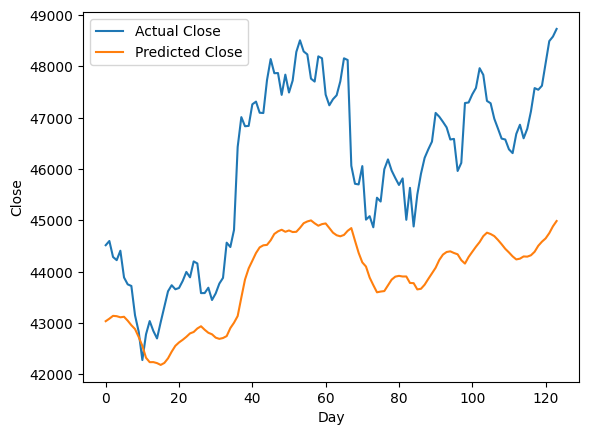

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
